<a href="https://colab.research.google.com/github/AngelicaDC/BEDUpython/blob/main/Corrupt_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importamos las librerias

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

#### Preguntas para este analisis
- ¿Que tan eficiente es la metodologia de la ASF para elegir auditar las secciones correctas del presupuesto publico?
- ¿Existen patrones en la presencia de anomalias (dinero faltante) en el manejo de los recursos?
- ¿Que "caracterizticas" estan mejor relacionadas con la incidencia de interes en el presupuesto publico?
- ¿Es posible estimar las probabilidades de incidencia para las anomalias en el presupuesto segun algunas de las caracterizticas del dataset?
- ¿Existe algun impacto notable de la corrupcion en la calidad de vida medida por el CPI?
- ¿Considerando los datos obtendos por la ASF y la todalidad del presupuesto publico que tan grave y frecuente se ve proyectada la corrupcion en mexico?
- ¿Es posible comprender o identificar patrones a partir de los datos en la forma en la que la ASF decide a quien y cuando auditar?
- ¿Existe alguna relacion entre la cantidad de presupuesto destinado a una seccion y la valoracion del CPI para ese topico?
- ¿Existe alguna relacion entre la cantidad de presupuesto destinado a una seccion y la cantidad de "corrupcion" detectada y/o proyectada?

#### Cargamos los datasets

In [2]:
ds_cpi = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/CPI_Mex_full.csv')

ds_cpi.head(3)

,estado,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Energía,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Proporción de generación de energía renovable,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,67.43,46.08,51.88,100.0,71.24,68.10,42.90,84.57,62.88,14.66,72.49,85.15,64.44,0.0,47.80,100.0,63.96,73.16,91.34,0.0,84.71,89.49,29.10,0.0,64.85,90.33,79.34,35.68,85.48,71.24,90.33,0.0,41.47,42.36,75.0,61.48,43.70,43.70,41.23,73.79,0.0,24.80,2.94,62.54,58.77,34.77,67.44,62.34,83.91,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,67.42,46.08,59.68,100.0,21.70,70.14,10.60,78.63,74.44,3.62,73.72,71.44,69.28,0.0,51.67,100.0,38.48,74.97,43.66,100.0,81.19,80.49,56.84,100.0,52.60,85.28,84.21,43.06,77.14,21.70,85.28,0.0,83.20,40.59,NaN,66.37,49.65,49.65,48.97,47.14,0.0,15.33,99.36,70.39,57.34,69.97,73.82,59.62,62.82,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73
2,Aguascalientes,San Francisco de los Romo,100.00,8.40,98.42,65.86,62.71,56.75,37.20,60.70,67.43,46.08,60.89,100.0,27.90,65.86,12.31,87.82,69.52,0.00,72.67,75.79,64.59,0.0,47.86,100.0,58.96,73.16,100.00,0.0,77.64,88.00,29.81,0.0,51.66,87.23,82.93,25.92,77.68,27.90,87.23,0.0,35.36,38.82,NaN,63.78,52.23,52.23,51.47,57.57,0.0,11.61,2.24,70.31,55.52,30.70,64.17,51.93,76.19,94.02,73.66,51.93,55.17,35.02,68.48,43.44,100.00,96.33,17.93


In [3]:
def get_money(text):

  if pd.isna(text):    
    return np.nan
  re_dinero = re.compile(r'monto de ([\d|,|\.]+) pesos')
  res = re_dinero.search(text)
  if res:
    re_num = re.compile(r'[^0-9]')
    return float(re.sub(re_num, '', res.groups()[0][:-3]))
  return np.nan

In [50]:
ds_asf = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/asf_2017-2019.csv',
     encoding='latin-1')
ds_asf['terminado'] = ds_asf['Estado de Trámite'].isin(['Con seguimiento concluido','Conclusión'])
ds_asf['desaparecido'] = ds_asf['Texto Acción'].apply(get_money)

ds_asf.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones,terminado,desaparecido
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1,False,1.342933e+09
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True,NaN


In [5]:
df_pres = pd.read_parquet('https://github.com/Erick-INCS/Corruption-analysis/blob/main/datasets/presupuesto_2017-2020.parquet?raw=true')
df_pres.head(5)

,CICLO_RECURSO,PROGRAMA_FONDO_CONVENIO_ESPECIFICO,DESC_PARTIDA_GENERICA,DESC_TIPO_GASTO,ID_RAMO,MONTO_RECAUDADO,TRIMESTRE,MONTO_APROBADO,ID_PARTIDA_GENERICA,MONTO_EJERCIDO,MONTO_PAGADO,MONTO_DEVENGADO,MONTO_COMPROMETIDO,MONTO_MODIFICADO,TIPO_RECURSO,CICLO,DESC_RAMO,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCION_EJECUTORA
0,2008,FAM 2008,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,4.869210e+05,1,4.869210e+05,421,4.572240e+05,4.572240e+05,4.572240e+05,4.605600e+05,4.869210e+05,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
1,2010,FAM 2010,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,1.526132e+06,1,1.526132e+06,421,8.520000e+05,8.520000e+05,8.520000e+05,1.457215e+06,1.526132e+06,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
2,2012,SIN IDENTIFICAR,Sueldos base al personal permanente,Gasto corriente,33,3.564887e+08,1,3.564887e+08,113,3.564887e+08,3.564887e+08,3.564887e+08,3.564887e+08,3.564887e+08,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...
3,2012,SIN IDENTIFICAR,Honorarios asimilables a salarios,Gasto corriente,33,9.583701e+04,1,9.583701e+04,121,9.583701e+04,9.583701e+04,9.583701e+04,9.583701e+04,9.583701e+04,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...
4,2012,SIN IDENTIFICAR,Sueldos base al personal eventual,Gasto corriente,33,9.259750e+07,1,9.259750e+07,122,9.259750e+07,9.259750e+07,9.259750e+07,9.259750e+07,9.259750e+07,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...


Postwork 1
1.   Promedio
2.   Mediana
3.   Media Truncada
4.   Desviación estándar
5.   Rango
6.  Percentiles 25 y 75 (por lo menos)
7.   Rango intercuartil

In [54]:
# Limpieza de data set ds_asf  len(ds_asf), len(ds_asf2) = (32404, 21606)
# Filtramos los datos de acuerdo a los Tipos de Accion que presentan indicios de corrupcion 
ds_asf2 = ds_asf[ds_asf['Tipo Acción'].isin([
                           'Pliego de Observaciones', 
                           'Promoción de Responsabilidad Administrativa Sancionatoria', 
                           'Informe de Presunta Responsabilidad Administrativa',
                           'Promoción del Ejercicio de la Facultad de Comprobación Fiscal'])
]
ds_asf2.dropna(subset = ["desaparecido"], inplace=True) #len(ds_asf2) = 5724

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [67]:
def describe_chido(df, columnas = []):
  if columnas:
    df = df[columnas]
  descripcion =df.describe()
  descripcion.loc['IQR'] = descripcion.loc['75%']-descripcion.loc['25%']
  df['desaparecido'].sort_values(ascending= True)
  descripcion.loc['media trunca'] = stats.trim_mean(df['desaparecido'], .05)
  
  return descripcion

In [68]:
describe_chido(ds_asf2,['desaparecido'])

,desaparecido
count,5.724000e+03
mean,3.769404e+07
std,2.119436e+08
min,5.300000e+01
25%,2.980608e+05
50%,1.734742e+06
75%,1.080350e+07
max,7.317874e+09
IQR,1.050544e+07
media trunca,1.112776e+07


In [ ]:
ds_asf2.describe(), print('mediana', ds_asf2['desaparecido'].median())

mediana 1734742.0


(       Año Cuenta Pública        Número  Auditorías  Acciones  desaparecido
 count        21606.000000  21606.000000     21606.0   21606.0  5.724000e+03
 mean          2016.267611   1008.307415         1.0       1.0  3.769404e+07
 std              1.515952    407.089893         0.0       0.0  2.119436e+08
 min           2014.000000     11.000000         1.0       1.0  5.300000e+01
 25%           2015.000000    713.000000         1.0       1.0  2.980608e+05
 50%           2016.000000   1022.000000         1.0       1.0  1.734742e+06
 75%           2017.000000   1326.000000         1.0       1.0  1.080350e+07
 max           2019.000000   1881.000000         1.0       1.0  7.317874e+09,
 None)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


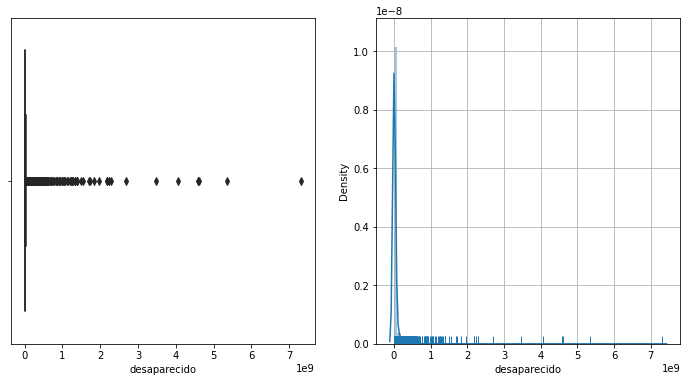

In [ ]:
fig,axes=plt.subplots(1,2, figsize=(12,6))
sns.boxplot(ds_asf2['desaparecido'], ax=axes[0],color='purple')
plt.grid(True)
sns.distplot(ds_asf2['desaparecido'], rug=True, ax=axes[1], kde=True, norm_hist=False, bins=80) 
plt.show();

In [ ]:
iqr = ds_asf2['desaparecido'].quantile(0.75) - ds_asf2['desaparecido'].quantile(0.25)
filtro_inferior = ds_asf2['desaparecido'] > ds_asf2['desaparecido'].quantile(0.25) - (iqr * 1.5)
filtro_superior = ds_asf2['desaparecido'] < ds_asf2['desaparecido'].quantile(0.75) + (iqr * 1.5)
ds_asf2_filtrado = ds_asf2[filtro_inferior & filtro_superior]
print('rango intercuartilico: ', iqr)

rango intercuartilico:  10505437.5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


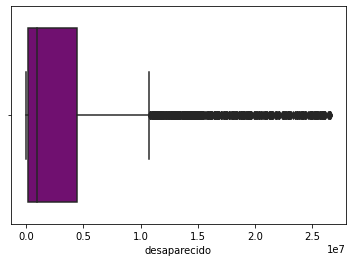

In [ ]:
sns.boxplot(ds_asf2_filtrado['desaparecido'],color='purple')

In [ ]:
df_pres.head(3)

,CICLO_RECURSO,PROGRAMA_FONDO_CONVENIO_ESPECIFICO,DESC_PARTIDA_GENERICA,DESC_TIPO_GASTO,ID_RAMO,MONTO_RECAUDADO,TRIMESTRE,MONTO_APROBADO,ID_PARTIDA_GENERICA,MONTO_EJERCIDO,MONTO_PAGADO,MONTO_DEVENGADO,MONTO_COMPROMETIDO,MONTO_MODIFICADO,TIPO_RECURSO,CICLO,DESC_RAMO,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCION_EJECUTORA
0,2008,FAM 2008,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,486921.0,1,486921.0,421,457224.0,457224.0,457224.0,460560.0,486921.0,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
1,2010,FAM 2010,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,1526132.0,1,1526132.0,421,852000.0,852000.0,852000.0,1457215.0,1526132.0,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
2,2012,SIN IDENTIFICAR,Sueldos base al personal permanente,Gasto corriente,33,356488747.2,1,356488747.2,113,356488747.2,356488747.2,356488747.2,356488747.2,356488747.2,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...


In [ ]:
len(df_pres)

823521

In [ ]:
# Monto aprobado es igual al monto pagado. El monto aprobado podriamos reemplazarlo por el comprmetido
((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) ==0).sum()  *100/len(df_pres)

15.575194803775496

In [ ]:
# Monto aprobado es diferente al monto pagado
((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) !=0).sum()  *100/len(df_pres)

84.4248051962245

In [ ]:
serie_AP = pd.Series((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']))
serie_AP_rel = pd.Series((df_pres['MONTO_APROBADO']/df_pres['MONTO_PAGADO']))

In [ ]:
serie_AP_neg = pd.Series(serie_AP[(df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) < -1000000])
serie_AP_pos = pd.Series(serie_AP[(df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) > 1000000])

In [ ]:
len(serie_AP_neg), len(serie_AP_pos)

(40517, 127956)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/li

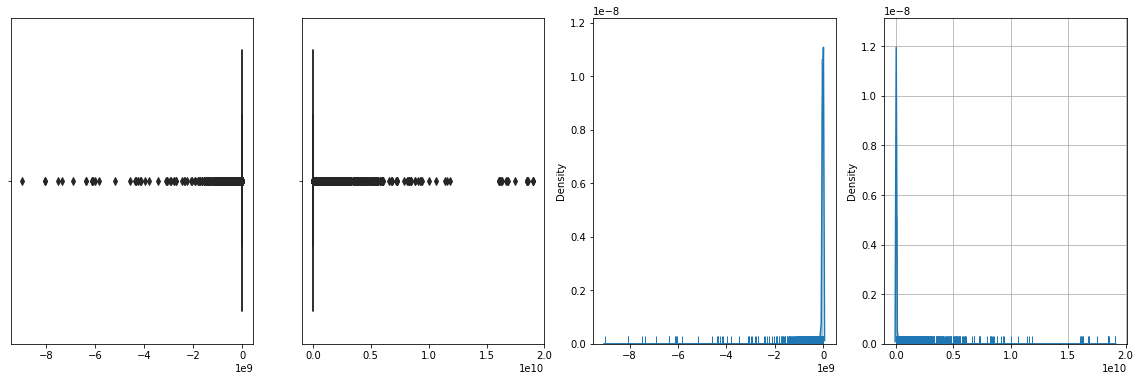

In [ ]:
fig,axes=plt.subplots(1,4, figsize=(20,6));
sns.boxplot(serie_AP_neg,color='purple', ax=axes[0]);
sns.boxplot(serie_AP_pos,color='purple', ax=axes[1]);
plt.grid(True);
sns.distplot(serie_AP_neg, rug=True, ax=axes[2], kde=True, norm_hist=False, bins=100);
sns.distplot(serie_AP_pos, rug=True, ax=axes[3], kde=True, norm_hist=False, bins=100); 


In [ ]:
serie_AP

0           29697.0
1          674132.0
2               0.0
3               0.0
4               0.0
            ...    
823516          0.0
823517          0.0
823518    -200000.0
823519    -400000.0
823520    1855853.0
Length: 823521, dtype: float64

In [ ]:
serie_AP.describe()

count    8.235210e+05
mean     4.487052e+06
std      1.276787e+08
min     -8.995841e+09
25%     -1.749000e+01
50%      9.201930e+03
75%      2.726182e+05
max      1.904910e+10
dtype: float64

In [ ]:
serie_AP_neg.describe()

count    4.051700e+04
mean    -2.363966e+07
std      1.696032e+08
min     -8.995841e+09
25%     -1.004768e+07
50%     -3.576766e+06
75%     -1.760774e+06
max     -1.000000e+06
dtype: float64

In [ ]:
serie_AP_pos.describe()

count    1.279560e+05
mean     3.607616e+07
std      3.073458e+08
min      1.000000e+06
25%      1.916121e+06
50%      4.017134e+06
75%      1.195609e+07
max      1.904910e+10
dtype: float64

In [ ]:
# Filtrar diferencias por rango intercurtilico
print('rango: ', serie_AP_pos.max() - serie_AP_pos.min())
iqr_AP_pos =  serie_AP_pos.quantile(0.75) -  serie_AP_pos.quantile(0.25)
filtro_inferior =  serie_AP_pos >  serie_AP_pos.quantile(0.25) - (iqr_AP_pos * 1.5)
filtro_superior =  serie_AP_pos <  serie_AP_pos.quantile(0.75) + (iqr_AP_pos * 1.5)
AP_pos_filtrado = serie_AP_pos[filtro_inferior & filtro_superior]
print('rango intercuartilico: ', iqr_AP_pos)

rango:  19048099634.0
rango intercuartilico:  10039964.815000001


In [ ]:
len(AP_pos_filtrado), len(serie_AP_pos)

(110035, 127956)

In [ ]:
AP_pos_filtrado.max() - AP_pos_filtrado.min()

26015184.189999998

In [ ]:
segmentos = pd.cut(AP_pos_filtrado, 100)
serie_AP_pos_segm= pd.Series(AP_pos_filtrado.groupby(segmentos).count())

In [ ]:
serie_AP_pos_segm

(973984.816, 1260151.842]       11849
(1260151.842, 1520303.684]       9448
(1520303.684, 1780455.526]       7232
(1780455.526, 2040607.368]       7005
(2040607.368, 2300759.21]        5155
                                ...  
(25714424.98, 25974576.822]       141
(25974576.822, 26234728.664]      166
(26234728.664, 26494880.506]      152
(26494880.506, 26755032.348]      157
(26755032.348, 27015184.19]       147
Length: 100, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


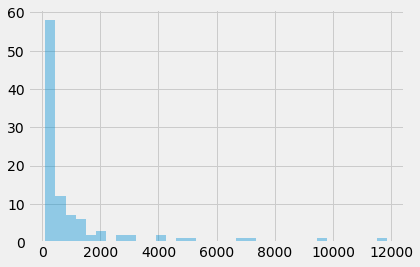

In [ ]:
plt.style.use('fivethirtyeight')
sns.distplot(serie_AP_pos_segm, kde=False, norm_hist=False);

In [ ]:
serie_AP_pos_sort=AP_pos_filtrado.sort_values(ascending= True)

In [ ]:
serie_AP_pos_sort.head(100).tail(20)

434446    1000908.24
320930    1000912.00
641140    1000928.00
554266    1000928.00
607740    1000949.12
518209    1000949.12
697703    1000949.12
232308    1000990.77
232305    1000990.77
323873    1000990.77
422172    1000990.77
515585    1000990.77
782512    1000997.49
572597    1001000.00
658834    1001000.00
749910    1001000.00
144107    1001032.84
562474    1001049.73
611466    1001090.36
173833    1001133.59
dtype: float64

In [ ]:
len(serie_AP_pos_sort)

110035

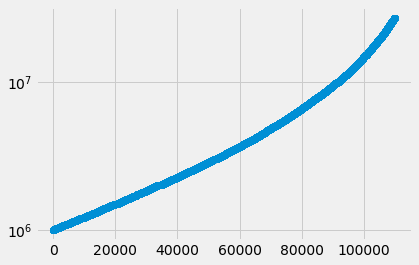

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(list(range(0,len(serie_AP_pos_sort))), serie_AP_pos_sort, marker='o', ls="") 
plt.show()

In [ ]:
serie_AP_pos_sort.kurtosis(), serie_AP_pos_sort.var(), serie_AP_pos_sort.skew()

(2.735346960363187, 31224959481286.99, 1.796846309818914)

## Postwork 3
1. Identifica todas las variables categóricas en tu dataset.
2. Utiliza gráficas de barras para explorar la distribución de tus variables categóricas.
3. Planea tu análisis multivariable: ¿qué combinaciones de variables categóricas podrían darme información útil acerca de la distribución de mis datos? ¿qué combinaciones de una variable numérica con una variable categórica podrían ser interesantes?
4. Utiliza tablas de contingencia y múltiples gráficas en la misma figure para explorar combinaciones de variables categóricas.
5. Utiliza boxplots y violinplots para explorar combinaciones de variables numéricas con variables categóricas.
6. De preferencia ve registrando por escrito (ahí mismo en tu Notebook) todos tus hallazgos. Describe qué vas descubriendo y qué podría significar.

##### Empezamos definiendo las variables categoricas como tal

In [43]:
ds_asf['Sector'] = ds_asf['Sector'].astype('category')
ds_asf['Ente Fiscalizado'] = ds_asf['Ente Fiscalizado'].astype('category') ## Aqui hay muchas :|
ds_asf['Entidad Federativa'] = ds_asf['Entidad Federativa'].astype('category')
ds_asf['Tipo Auditoría'] = ds_asf['Tipo Auditoría'].astype('category')
ds_asf['Ente a quien se dirige la Acción'] = ds_asf['Ente a quien se dirige la Acción'].astype('category')
ds_asf['Tipo Acción'] = ds_asf['Tipo Acción'].astype('category')
ds_asf['Estado de Trámite'] = ds_asf['Estado de Trámite'].astype('category')
ds_asf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5724 entries, 0 to 32397
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Año Cuenta Pública                5724 non-null   int64   
 1   Grupo Funcional                   5724 non-null   object  
 2   Sector                            5724 non-null   category
 3   Ente Fiscalizado                  5724 non-null   category
 4   Entidad Federativa                5724 non-null   category
 5   Tipo Auditoría                    5724 non-null   category
 6   Número                            5724 non-null   int64   
 7   Título                            5724 non-null   object  
 8   Universo (miles pesos)            5724 non-null   object  
 9   Muestra (miles pesos)             5724 non-null   object  
 10  Ente a quien se dirige la Acción  5724 non-null   category
 11  Tipo Acción                       5724 non-null   categ

In [44]:
def barplot(serie, title, xlabel, ylabel, rotation=0, axis=None):
  counts = serie.value_counts()
  ax = sns.barplot(y=counts.index, x=counts, ax=axis)
  ax.set_title(title)
  ax.set(ylabel=ylabel, xlabel=xlabel)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation);

In [45]:
ds_asf['Sector'] = ds_asf['Sector'].cat.rename_categories({'Previsiones y Aportaciones Para Los Sistemas de Educación Básica, Normal, Tecnológica y de Adultos':'Aportaciones para Educación'})

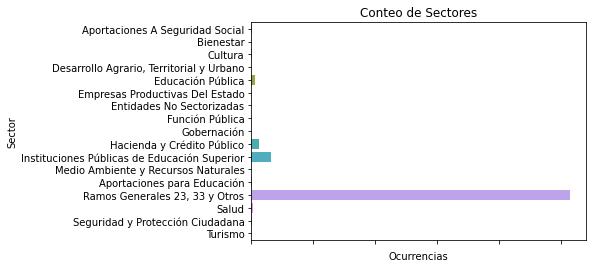

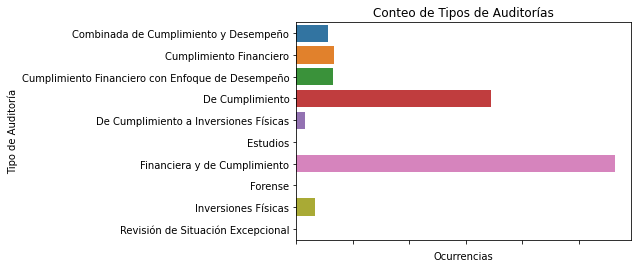

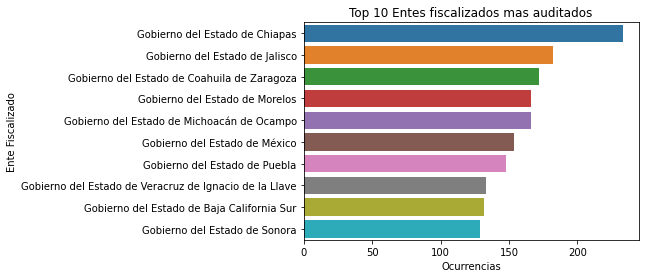

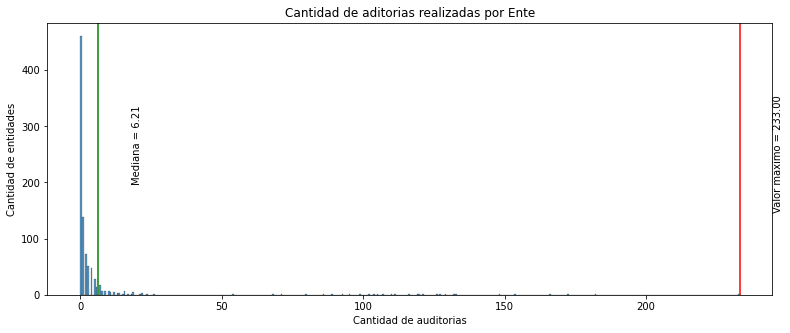

In [47]:
barplot(ds_asf['Sector'], 
        title='Conteo de Sectores', 
        ylabel='Sector', 
        xlabel='Ocurrencias')
plt.show(); print()

barplot(ds_asf['Tipo Auditoría'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

serie_entes = ds_asf['Ente Fiscalizado'].value_counts()
top10 = serie_entes.sort_values(ascending=False)[:10].reset_index().values
ax = sns.barplot(y=top10[:,0], x=top10[:,1])
ax.set_title('Top 10 Entes fiscalizados mas auditados')
ax.set(xlabel='Ocurrencias', ylabel='Ente Fiscalizado')
plt.show(); print()

plt.figure(figsize=(13, 5))
plt.title('Cantidad de aditorias realizadas por Ente')
plt.ylabel('Cantidad de entidades')
plt.xlabel('Cantidad de auditorias')
sns.histplot(serie_entes)

span=12
plt.axvline(serie_entes.mean(), color='g')
plt.text(
    serie_entes.mean() + span,
    200,
    f'Mediana = {serie_entes.mean():.2f}',
    rotation=90)

plt.axvline(serie_entes.max(), color='r')
plt.text(
    serie_entes.max() + span, 150,
    f'Valor maximo = {serie_entes.max():.2f}',
    rotation=90);

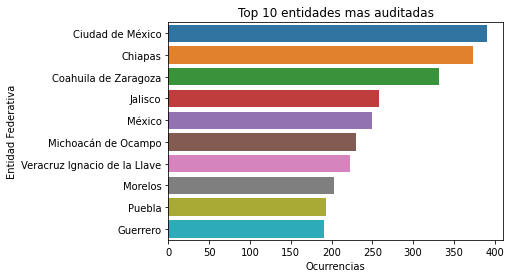

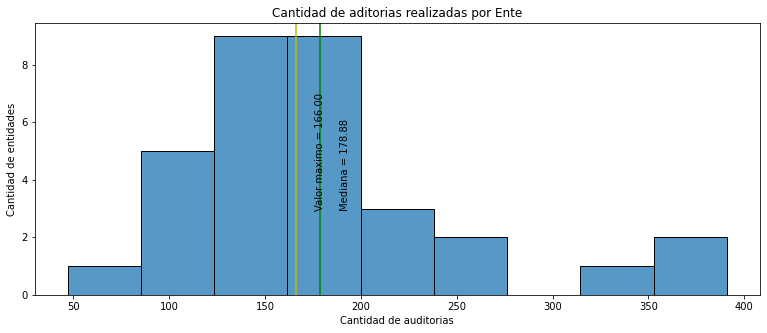

In [48]:
serie_entidad = ds_asf['Entidad Federativa'].value_counts()
top10 = serie_entidad.sort_values(ascending=False)[:10].reset_index().values
ax = sns.barplot(y=top10[:,0], x=top10[:,1])
ax.set_title('Top 10 entidades mas auditadas')
ax.set(xlabel='Ocurrencias', ylabel='Entidad Federativa')
plt.show(); print()

plt.figure(figsize=(13, 5))
plt.title('Cantidad de aditorias realizadas por Ente')
plt.ylabel('Cantidad de entidades')
plt.xlabel('Cantidad de auditorias')
sns.histplot(serie_entidad)

span=10
plt.axvline(serie_entidad.mean(), color='g')
plt.text(
    serie_entidad.mean() + span,
    3,
    f'Mediana = {serie_entidad.mean():.2f}',
    rotation=90)

plt.axvline(serie_entidad.median(), color='y')
plt.text(
    serie_entidad.median() + span, 
    3,
    f'Valor maximo = {serie_entidad.median():.2f}',
    rotation=90);

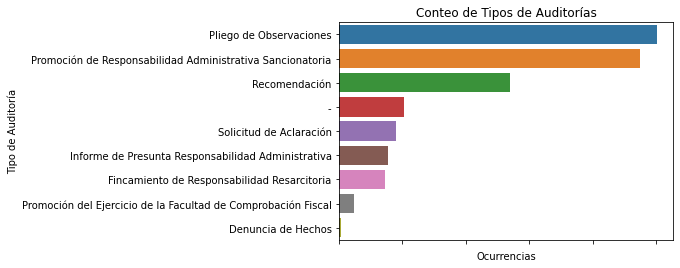

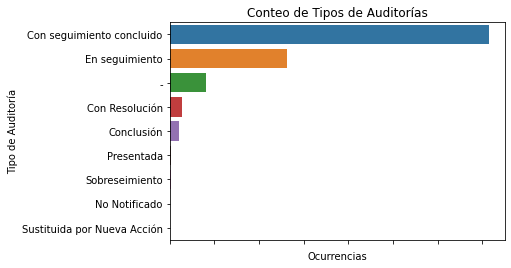

In [51]:
barplot(ds_asf['Tipo Acción'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

barplot(ds_asf['Estado de Trámite'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

# Postwork 4
Utilizando tu dataset, realiza las siguientes actividades:

* Identifica cuáles son las variables numéricas en tu dataset.
* Asegúrate de que tengan el tipo de dato correcto y que no haya NaNs por ahí escondidos.
* Genera una matriz de correlaciones y un pairplot para visualizar de manera general las relaciones entre tus variables numéricas.
* Utilizando gráficas de dispersión y tus medidas de locación y dispersión, identifica dónde hay valores atípicos y decide qué hacer con ellos.
* Revisa si tu revisión de valores atípicos cambió de alguna manera las relaciones existentes.
* Donde consideres necesario, entrena modelos de Regresión Lineal con un o más pares de variables. Incluso si no te parece que realizar predicciones entre pares de variables tiene sentido para tu proyecto, prueba realizar un par de regresiones para que practiques el procedimiento.

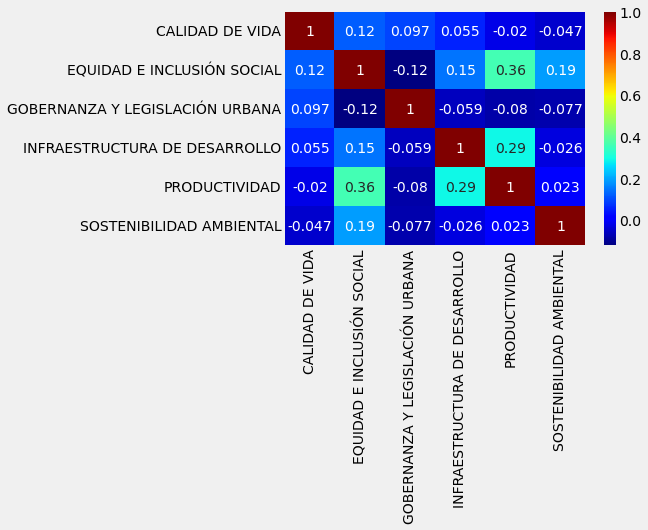

In [ ]:
ds_cpi.head(5)
ds_cpi_reducido =  ds_cpi[
                          list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]
ds_cpi_reducido = ds_cpi_reducido.set_index('estado')
ds_cpi_reducido

sns.heatmap(ds_cpi_reducido.corr(),cmap='jet', annot=True)

##PostWork 6

Graficamos los estados de la republica con su respectiva suma de dinero perdido

In [ ]:
import folium

In [ ]:
ds_asf.head()

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones,terminado,desaparecido
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1,False,1.342933e+09
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True,NaN
2,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-004,-,La Auditoría Superior de la Federación emite l...,En seguimiento,1,1,False,NaN
3,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-002,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True,NaN
4,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-003,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True,NaN


Obtenemos el dinero por perdido por estado


In [ ]:
dinero_por_estado = ds_asf.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa'])['desaparecido'].aggregate(['sum', 'count'])
dinero_por_estado = dinero_por_estado.reset_index()
dinero_por_estado['dinero_segun_auditorias'] = dinero_por_estado['sum'] / dinero_por_estado['count']
dinero_por_estado

,Entidad Federativa,sum,count,dinero_segun_auditorias
0,Aguascalientes,1.865944e+09,117,1.594824e+07
1,Baja California,1.718964e+09,128,1.342941e+07
2,Baja California Sur,2.950292e+09,175,1.685881e+07
3,Campeche,1.265970e+09,129,9.813718e+06
4,Chiapas,1.314974e+10,389,3.380397e+07
5,Chihuahua,5.474594e+09,149,3.674224e+07
6,Ciudad de México,3.089786e+10,395,7.822244e+07
7,Coahuila de Zaragoza,6.887259e+09,337,2.043697e+07
8,Colima,1.583675e+09,148,1.070051e+07
9,Durango,1.637358e+09,104,1.574383e+07


## Falta el crolopletico del CPI


In [ ]:
ds_cpi_reducido =  ds_cpi[    list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]
ds_cpi_reducido = ds_cpi_reducido.set_index('estado').join(dinero_por_estado.set_index('Entidad Federativa')).reset_index().rename(columns={'index':'estado'})
df_cpi_GobLeg = ds_cpi_reducido.groupby('estado')['GOBERNANZA Y LEGISLACIÓN URBANA'].aggregate(['mean'])
df_cpi_CV = ds_cpi_reducido.groupby('estado')['CALIDAD DE VIDA'].aggregate(['mean'])


df_cpi_GobLeg=df_cpi_GobLeg.reset_index()
df_cpi_CV=df_cpi_CV.reset_index()


In [ ]:
mexico_json = "https://raw.githubusercontent.com/Forever-D14/DataScienceBEDU/main/Modulo%205%20-%20Python/Remoto%20mexico.json"

def renom_estados(name):
  estados = {
    'Michoacán de Ocampo': 'Michoacán', 
    'México': 'Estado de México', 
    'Veracruz Ignacio de la Llave': 'Veracruz',
    'Coahuila de Zaragoza': 'Coahuila'}

  if name in estados:
    return estados[name]
  
  return name
df_cpi_GobLeg['estado'] = df_cpi_GobLeg['estado'].map(renom_estados)
df_cpi_CV['estado'] = df_cpi_CV['estado'].map(renom_estados)

dinero_por_estado['Entidad Federativa'] = dinero_por_estado['Entidad Federativa'].map(renom_estados)
dinero_por_estado['Dinero Perdido(MDP)']=dinero_por_estado['sum']/1_000_000_000

In [ ]:
m = folium.Map(location=[24.1245102,-103.4520039],zoom_start=5.46,)

##Cloropletico de Dinero Perdido
folium.Choropleth(
    geo_data = mexico_json,
    name='Dinero Perdido En México',
    data = dinero_por_estado,
    columns=['Entidad Federativa','Dinero Perdido(MDP)'],
    key_on='feature.properties.name',
    fill_color="YlGnBu",
    legend_name="Dinero Perdido MDP",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

##Cloropletico de Gobernanza y Legislación
folium.Choropleth(
    geo_data = mexico_json,
    name='Promedio de Gobernanza y Legislación Urbana',
    data = df_cpi_GobLeg,
    columns=['estado','mean'],
    key_on='feature.properties.name',
    fill_color="YlOrRd",
    legend_name="Puntos de Gobernanza y Legislación Urbana",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

##Cloropletico de Calidad de Vida
folium.Choropleth(
    geo_data = mexico_json,
    name='Promedio de Calidad de Vida',
    data = df_cpi_CV,
    columns=['estado','mean'],
    key_on='feature.properties.name',
    fill_color="Oranges",
    legend_name="Puntos de Calidad de Vida",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)


folium.LayerControl().add_to(m)

m